In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import random

In [1]:
TRAIN_DIR= "./cards-image-dataset/train"
VALID_DIR= "./cards-image-dataset/valid"
TEST_DIR= "./cards-image-dataset/test"

# Initialize TensorBoard

In [3]:
from tensorflow.keras.callbacks import ModelCheckpoint

tsb=tf.keras.callbacks.TensorBoard(log_dir="logs")
checkpoint_path = "best_custom_model_github.keras"

# Configuração do callback ModelCheckpoint
checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_path,        # Caminho onde o modelo será salvo
    monitor='val_accuracy',  # Métrica a ser monitorada (ajuste conforme necessário)
    save_best_only=True,             # Salva somente o melhor modelo
    mode='max',                      # 'max' para maior acurácia, 'min' para menor perda
    verbose=1                        # Exibe uma mensagem a cada salvamento
)

# Create String Labels

In [4]:
import json
import os
classes=[i for i in os.listdir(TRAIN_DIR)]

with open("classes.json", "w") as f:
    json.dump(classes, f)


# Create Training Dataset

In [5]:
test=[]
for i in os.listdir(TEST_DIR):
    current_path=os.path.join(TEST_DIR,i)
    current_class=classes.index(i)
    for j in os.listdir(current_path):
        try:
            img=cv2.imread(os.path.join(TEST_DIR,i,j),cv2.IMREAD_GRAYSCALE)
            img=cv2.resize(img,(224,224))
        except:
            continue
        test.append([img,current_class])
random.shuffle(test)
x_test=[]
y_test=[]
for i,j in test:
    x_test.append(i)
    y_test.append(j)
x_test=np.array(x_test)
y_test=np.array(y_test)
print(f"Total Valid Images : {len(x_test)}")

Total Valid Images : 1117


In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Configuração do ImageDataGenerator com aumento de dados
test_datagen = ImageDataGenerator(
)

# Carregar imagens em escala de cinza diretamente do diretório
test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=(224, 224),
    color_mode='grayscale',  # Define para carregar em escala de cinza
    batch_size=32,
    class_mode='sparse'
)

print("Total de classes:", test_generator.num_classes)


Found 1117 images belonging to 52 classes.
Total de classes: 52


In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Configuração do ImageDataGenerator com aumento de dados
valid_datagen = ImageDataGenerator(
)

# Carregar imagens em escala de cinza diretamente do diretório
valid_generator = valid_datagen.flow_from_directory(
    VALID_DIR,
    target_size=(224, 224),
    color_mode='grayscale',  # Define para carregar em escala de cinza
    batch_size=32,
    class_mode='sparse'
)

print("Total de classes:", valid_generator.num_classes)


Found 1058 images belonging to 52 classes.
Total de classes: 52


In [8]:

# Configuração do ImageDataGenerator com aumento de dados
train_datagen = ImageDataGenerator(
    width_shift_range=0.35,
    brightness_range=(0.9, 1.10),
    fill_mode='constant',
)

# Carregar imagens em escala de cinza diretamente do diretório
train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(224, 224),
    color_mode='grayscale',  # Define para carregar em escala de cinza
    batch_size=32,
    class_mode='sparse'
)

print("Total de classes:", train_generator.num_classes)


Found 5037 images belonging to 52 classes.
Total de classes: 52


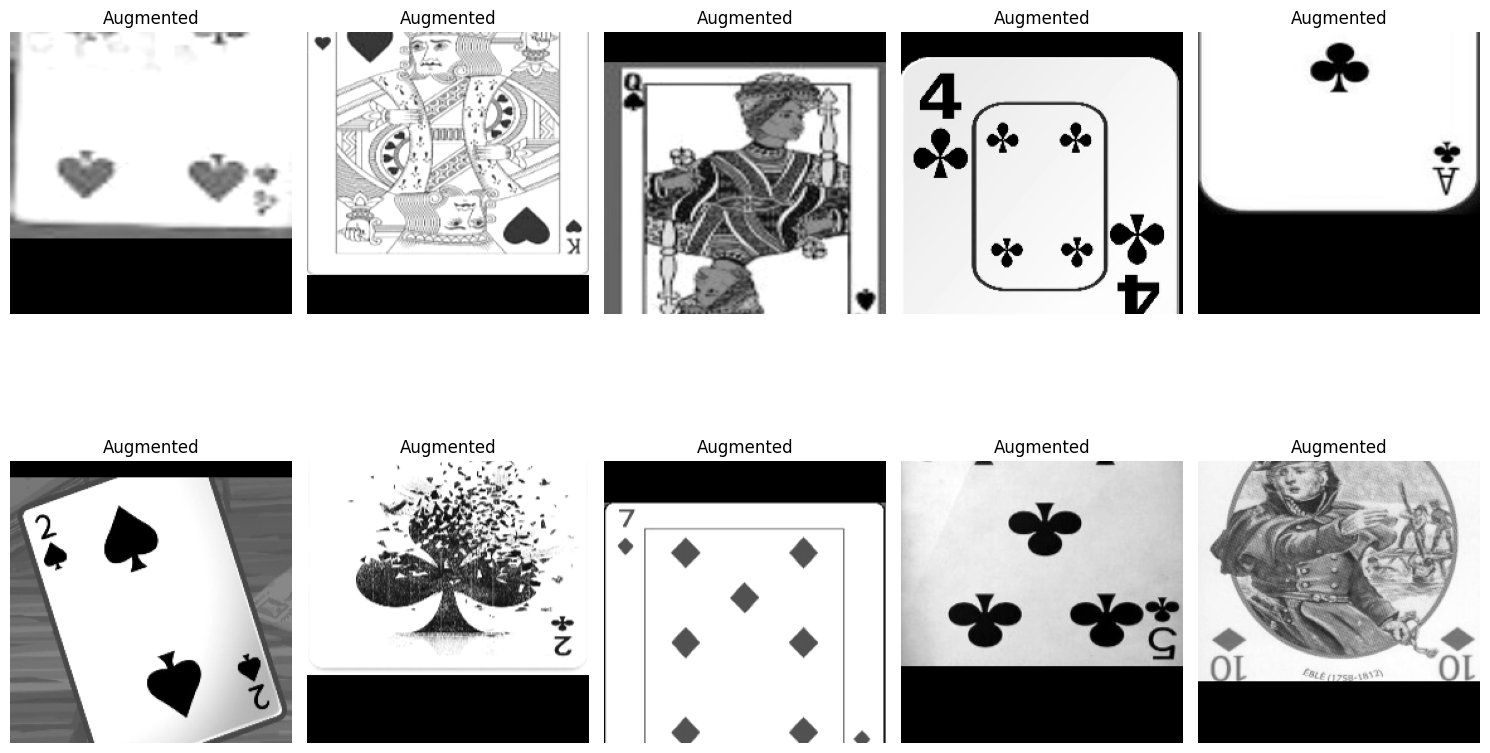

In [9]:
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Obter um batch de imagens originais e um com aumentação
augmented_images, _ = next(train_generator)

# Plotar imagens lado a lado: sem aumentação e com aumentação
plt.figure(figsize=(15, 10))
for i in range(10):
    # Imagens com aumentação
    plt.subplot(2, 5, i + 1)
    plt.imshow(augmented_images[i].squeeze(), cmap='gray')
    plt.axis('off')
    plt.title("Augmented")

plt.tight_layout()
plt.show()


# Create Model

In [ ]:
from tensorflow.keras.callbacks import LearningRateScheduler
import tensorflow as tf

# Função de scheduler para o learning rate
def lr_scheduler(epoch, lr, initial_lr=0.001, decay_rate=0.9, step_size=10, min_lr=0.0001):
    # Calcula o novo learning rate com base na época
    lr = initial_lr * (decay_rate ** (epoch // step_size))
    # Aplica o limite mínimo
    return max(lr, min_lr)

# Criando o callback do Learning Rate Scheduler
lr_scheduler_callback = LearningRateScheduler(lr_scheduler, verbose=1)


In [11]:

model=tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(224, 224, 1)),  # Define explicitamente a camada de entrada
    tf.keras.layers.Rescaling(1./255),  # Normaliza diretamente no modelo
    tf.keras.layers.Conv2D(128,(3,3),activation=tf.nn.relu,input_shape=(224,224,1)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(64,(3,3),activation=tf.nn.relu),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(64,(3,3),activation=tf.nn.relu),
    tf.keras.layers.MaxPooling2D(),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512,activation=tf.nn.relu),
    tf.keras.layers.Dropout(0.35),
    tf.keras.layers.Dense(256,activation=tf.nn.relu),
    tf.keras.layers.Dense(len(classes), activation="softmax")
])

model.summary()

c:\Users\rapha\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 224, 224, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 222, 222, 128)  │         1,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 222, 222, 128)  │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 43264)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    22,151,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 52)             │        13,364 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,408,884 (85.48 MB)

 Trainable params: 22,408,628 (85.48 MB)

 Non-trainable params: 256 (1.00 KB)

# Get Summary Of Model

# Compile The Model

In [12]:
model.compile(optimizer="adam",loss="sparse_categorical_crossentropy",metrics=["accuracy"])

# Train The Model

In [13]:
history=model.fit(train_generator, epochs=60,callbacks=[tsb, checkpoint_callback, lr_scheduler_callback],validation_data=valid_generator)

c:\Users\rapha\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()



Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/60
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.0304 - loss: 4.1984
Epoch 1: val_accuracy improved from -inf to 0.02647, saving model to best_custom_model_github.keras
158/158 ━━━━━━━━━━━━━━━━━━━━ 544s 3s/step - accuracy: 0.0305 - loss: 4.1967 - val_accuracy: 0.0265 - val_loss: 3.9332 - learning_rate: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.001.
Epoch 2/60
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.0794 - loss: 3.4842
Epoch 2: val_accuracy improved from 0.02647 to 0.08318, saving model to best_custom_model_github.keras
158/158 ━━━━━━━━━━━━━━━━━━━━ 538s 3s/step - accuracy: 0.0795 - loss: 3.4837 - val_accuracy: 0.0832 - val_loss: 3.6197 - learning_rate: 0.0010

Epoch 3: LearningRateScheduler setting learning rate to 0.001.
Epoch 3/60
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.1606 - loss: 3.0796
Epoch 3: val_accuracy improved from 0.08318 to 0.26087, saving mod

# Accuracy Graph

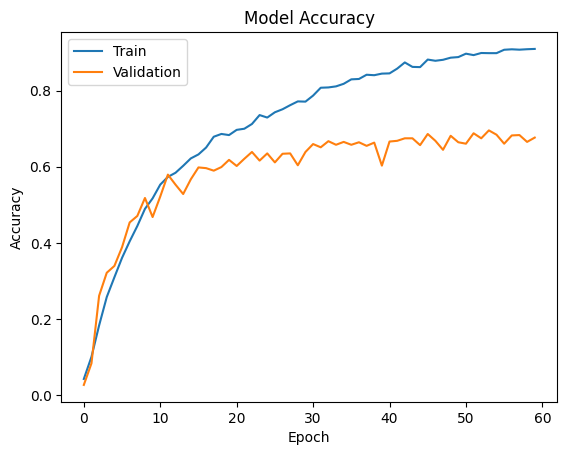

In [14]:
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title("Model Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Train","Validation"],loc="best")

# Loss Graph

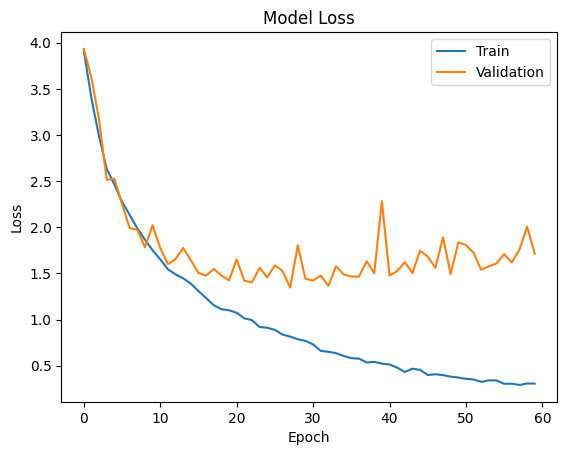

In [15]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("Model Loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Train","Validation"],loc="best")

# Predict On Images

In [16]:
def prepare(filepath):
    img = tf.keras.preprocessing.image.load_img(filepath, target_size=(224, 224), color_mode='grayscale')
    
    # Converter a imagem para um array de NumPy e expandir a dimensão para incluir o batch size
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Aumenta a dimensão para (1, 224, 224, 1)
    return img_array

In [ ]:
from tensorflow.keras.models import load_model
best_model = load_model("best_custom_model_github73,25%.keras")

best_model.evaluate(x_test, y_test)

35/35 ━━━━━━━━━━━━━━━━━━━━ 20s 563ms/step - accuracy: 0.7481 - loss: 1.7477


[1.8765957355499268, 0.726051926612854]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
jack of hearts


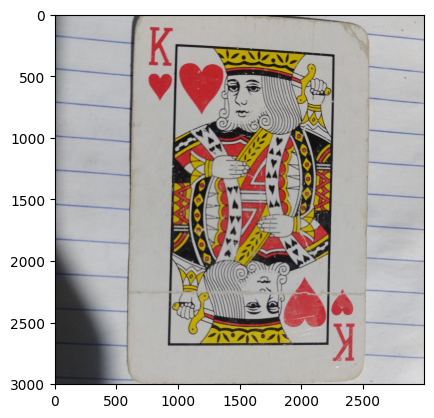

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
ten of hearts


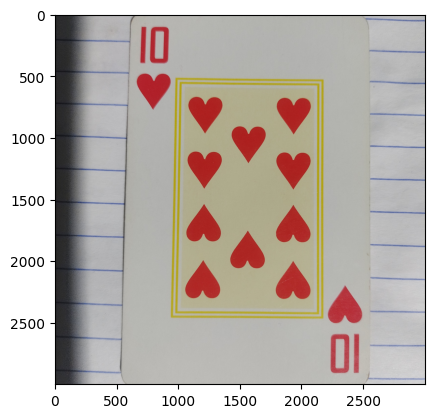

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
jack of hearts


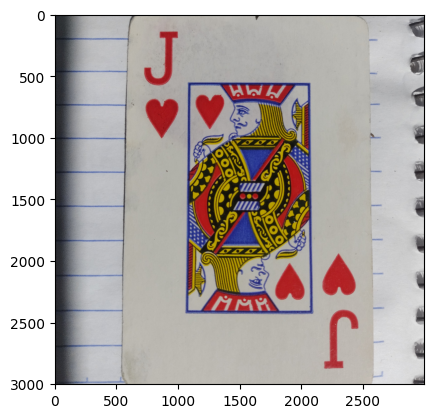

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
two of hearts


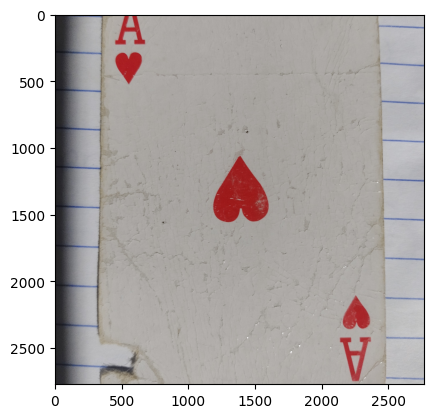

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
jack of hearts


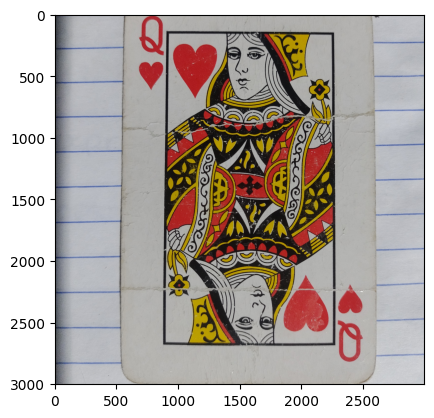

In [24]:
path = "./cards-image-dataset/input1/"
for i in os.listdir(path):
    for img in os.listdir(os.path.join(path, i)):
        img_path = f"{path}/{i}/{img}"
        
        prediction = best_model.predict(prepare(img_path))
        
        predicted_class = classes[int(np.argmax(prediction))]
        print(predicted_class)

        img = plt.imread(img_path)
        plt.imshow(img)
        plt.show()  # Exibe a imagem imediatamente

        # Faz a predição e imprime a classe
        plt.close() 

35/35 ━━━━━━━━━━━━━━━━━━━━ 20s 567ms/step


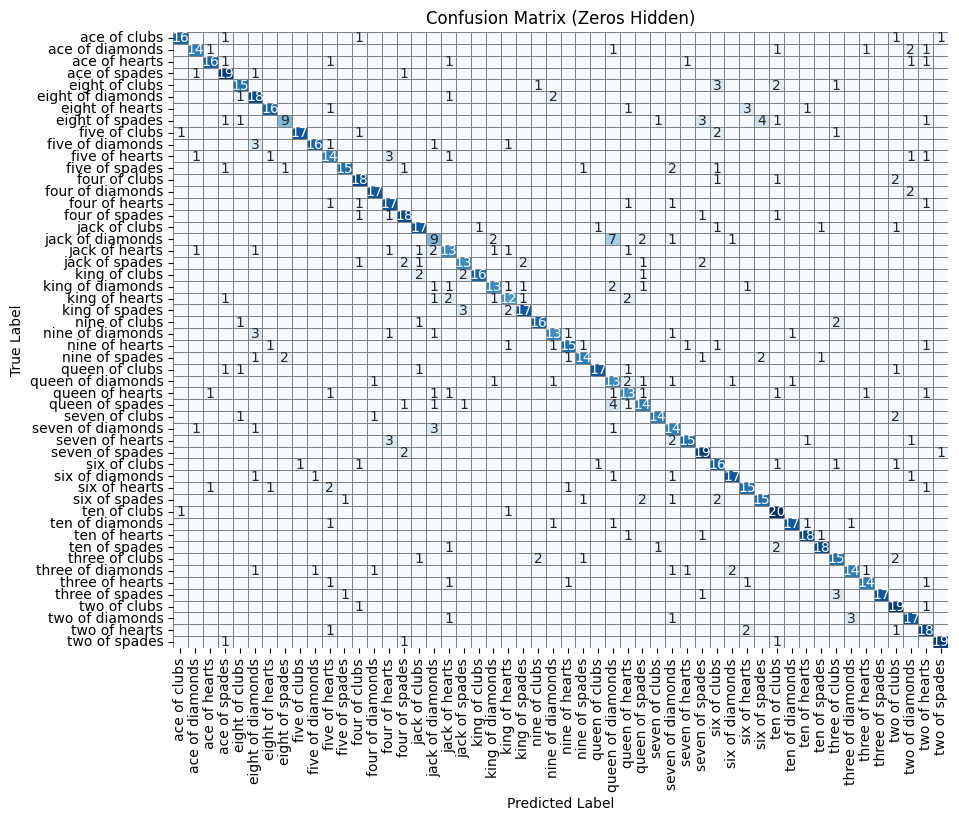

In [25]:
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix

# Obter as previsões do modelo no conjunto de teste
y_true = y_test  # rótulos reais do conjunto de teste
y_pred = np.argmax(best_model.predict(x_test), axis=1)  # previsões do modelo no conjunto de teste

# Gerar a matriz de confusão
conf_matrix = confusion_matrix(y_true, y_pred)

# Criar uma matriz de anotação que esconde os zeros
annot = np.where(conf_matrix == 0, '', conf_matrix)

# Função para plotar a matriz de confusão
def plot_confusion_matrix(conf_matrix, annot, class_names):
    plt.figure(figsize=(10, 8))
    
    # Cria um mapa de calor com a matriz de anotação customizada
    sns.heatmap(conf_matrix, annot=annot, fmt='', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names, 
                cbar=False, annot_kws={"size": 10}, linewidths=0.5, linecolor='grey')
    
    # Adiciona labels e título
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix (Zeros Hidden)')
    plt.show()

# Plotar a matriz de confusão com os nomes das classes
plot_confusion_matrix(conf_matrix, annot, classes)


In [20]:
history=model.fit(train_generator, initial_epoch=len(history.epoch), epochs=60+40,callbacks=[tsb, checkpoint_callback, lr_scheduler_callback],validation_data=valid_generator)


Epoch 61: LearningRateScheduler setting learning rate to 0.0006561000000000001.
Epoch 61/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9252 - loss: 0.2603
Epoch 61: val_accuracy improved from 0.69565 to 0.69943, saving model to best_custom_model_github.keras
158/158 ━━━━━━━━━━━━━━━━━━━━ 565s 4s/step - accuracy: 0.9252 - loss: 0.2603 - val_accuracy: 0.6994 - val_loss: 1.7304 - learning_rate: 6.5610e-04

Epoch 62: LearningRateScheduler setting learning rate to 0.0006561000000000001.
Epoch 62/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9215 - loss: 0.2613
Epoch 62: val_accuracy did not improve from 0.69943
158/158 ━━━━━━━━━━━━━━━━━━━━ 565s 4s/step - accuracy: 0.9214 - loss: 0.2613 - val_accuracy: 0.6796 - val_loss: 1.6528 - learning_rate: 6.5610e-04

Epoch 63: LearningRateScheduler setting learning rate to 0.0006561000000000001.
Epoch 63/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9252 - loss: 0.2778
Epoch 63: val_accuracy did not improve from 0.69

In [21]:
history=model.fit(train_generator, initial_epoch=len(history.epoch), epochs=60+40+20,callbacks=[tsb, checkpoint_callback, lr_scheduler_callback],validation_data=valid_generator)


Epoch 41: LearningRateScheduler setting learning rate to 0.0008100000000000001.
Epoch 41/120
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9609 - loss: 0.1435
Epoch 41: val_accuracy did not improve from 0.73251
158/158 ━━━━━━━━━━━━━━━━━━━━ 578s 4s/step - accuracy: 0.9608 - loss: 0.1436 - val_accuracy: 0.7070 - val_loss: 1.9791 - learning_rate: 8.1000e-04

Epoch 42: LearningRateScheduler setting learning rate to 0.0008100000000000001.
Epoch 42/120
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9500 - loss: 0.1629
Epoch 42: val_accuracy did not improve from 0.73251
158/158 ━━━━━━━━━━━━━━━━━━━━ 574s 4s/step - accuracy: 0.9499 - loss: 0.1630 - val_accuracy: 0.7023 - val_loss: 1.9779 - learning_rate: 8.1000e-04

Epoch 43: LearningRateScheduler setting learning rate to 0.0008100000000000001.
Epoch 43/120
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9415 - loss: 0.2013
Epoch 43: val_accuracy did not improve from 0.73251
158/158 ━━━━━━━━━━━━━━━━━━━━ 575s 4s/step - accu

KeyboardInterrupt: 